In [1]:
import re
import pickle
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple

from dateutil.relativedelta import relativedelta

from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import set_random_seed

set_random_seed(0)

In [2]:
df = pd.read_csv('data_for_train/consumption_and_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


In [3]:
calendar = pd.read_excel('data_for_train/calendar.xlsx', index_col='day')
print('calendar.shape', calendar.shape)
calendar.head(7)

calendar.shape (2922, 1)


,day_off
day,
2016-01-01,1
2016-01-02,1
2016-01-03,1
2016-01-04,0
2016-01-05,0
2016-01-06,0
2016-01-07,1


Для предсказания потребления воспользуемся нейронной сетью c двумя входами, созданной с помощью tensorflow.keras. Первый вход будет для рекуррентной части, второй - для полносвязной. Подготовим данные:

In [ ]:
def make_data(df               : pd.DataFrame,
              calendar         : pd.DataFrame,
              y_lags           : List[int],
              time_freq        : List[str],
              ) -> pd.DataFrame:
    """
    Функция, формирующая датасет для обучения рекуррентной нейронной сети.
    На вход требует:

    Датафрейм df, содержащий данные о почасовом потреблении и темпераутре.

    Датафрейм calendar, содержащий данные о том, выходной день или нет.

    Список лагов для целевой переменной, по которым будет осуществляться сдвиг во времени вперед.
    Рекомендуется давать начиная с единицы. Последнее значение не включается.

    Список частот, по которым необходимо кодировать текущую время и дату.
    Доступны: {'hour', 'day_of_year', 'month', 'weekday'}

    Логическое значение True/False на включение в датасет целевой переменной.
    """
    time_dict = {'hour'        : 24,
                 'day_of_year' : 365.25,
                 'month'       : 12,
                 'weekday'     : 7}

    # так как планируется применять данную функцию и для подготовки данных для предсказания
    # без известного заранее результата, раширим датафрейм вперед, для того, чтобы знать дату и время
    new_index = pd.date_range(start=df.index[-1], periods=y_lags[-1] + 1, freq='H')[y_lags[0] + 1:]
    df = pd.concat([df, pd.DataFrame(index=new_index)])

    # следующеие фичи нужны для рекуррентного входа

    # присоединим информацию о выходных и рабочих днях
    df['date'] = pd.to_datetime(df.index.date, format='%Y-%m-%d')
    df = pd.merge(df, calendar, left_on='date', right_index=True, how='left')
    df.drop('date', axis=1, inplace=True)

    # извлечем тригонометрическую фичу из времени
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for time_component in time_freq:
            df[time_component] = getattr(df.index, time_component)
            df[f'{time_component}_sin'] = np.sin( 2 * np.pi * df[time_component] / time_dict[time_component])
            df[f'{time_component}_cos'] = np.cos( 2 * np.pi * df[time_component] / time_dict[time_component])
            df.drop([time_component], axis=1, inplace=True)

    # следующеие фичи нужны для полносвязного входа
    
    # присоединим к вектору из данных о потреблении и температуре данные о времени,
    # назначенном для конкретного предсказания, а также инфу о рабочем/выходном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            for time_component in time_freq:
                df[f'{time_component}_sin_{lag}'] = df[f'{time_component}_sin'].shift(-lag - 1)
                df[f'{time_component}_cos_{lag}'] = df[f'{time_component}_cos'].shift(-lag - 1)
            df[f'day_off_{lag}'] = df['day_off'].shift(-lag - 1)
    
    # присоединим к вектору данные о прошлогоднем потреблении и температуре в этот же час,
    # а также сведения о выходном/праздничном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # создадим временный датафрейм, расширенный на год назад, чтобы получить временные сдвиги
        temp_df = pd.concat(
                                [
                                    pd.DataFrame(columns=df.columns,
                                                 index = pd.date_range(start=df.index[0] - relativedelta(years=1),
                                                                       end=df.index[0],
                                                                       freq='H')[:-1]),
                                    df[['one_hour_consumption', 'one_hour_temperature', 'day_off']].copy()

                                ],
                                axis=0
                            )

        for lag in tqdm(y_lags):
            # получим соответствующие лагу индексы
            shifted_index = tuple(index - relativedelta(years=1) + relativedelta(hours=lag + 1) for index in df.index)
            # получим значения по временным сдвигам
            df[[f'one_hour_consumption_previos_year_{lag}',
                f'one_hour_temperature_previos_year_{lag}',
                f'day_off_previos_year_{lag}']] = \
                    temp_df.loc[pd.DatetimeIndex(shifted_index), 
                                ['one_hour_consumption', 'one_hour_temperature', 'day_off']].values

    # в конце добавим нашу целевую переменную
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            df[f'y_{lag}'] = df['one_hour_consumption'].shift(-lag - 1)
    
    # удалим строки, содержащие Nan
    df.dropna(axis=0, inplace=True)

    return df

In [ ]:
y_lags=list(range(12, 36))
time_freq = ['hour', 'day_of_year', 'month', 'weekday']

dataset = make_data(df               =df,
                    calendar         =calendar,
                    y_lags           =y_lags,
                    time_freq        =time_freq)

pd.set_option("display.max_columns", dataset.shape[-1])
print('dataset.shape', dataset.shape)

dataset.to_csv('data_for_train/3.5/dataset.csv')

In [4]:
dataset = pd.read_csv('data_for_train/3.5/dataset.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S')
print('dataset.shape', dataset.shape)
dataset.head(2)

dataset.shape (56185, 323)


,one_hour_consumption,one_hour_temperature,day_off,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,month_sin,month_cos,weekday_sin,...,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35
2016-12-31 11:00:00,4341.80,-0.04,1,2.588190e-01,-0.965926,0.012901,0.999917,-2.449294e-16,1.0,-0.974928,...,3522.000000,3552.016667,3646.800000,3832.866667,4026.050000,4011.366667,3992.15,3977.700000,3789.233333,3599.683333
2016-12-31 12:00:00,4288.05,0.20,1,1.224647e-16,-1.000000,0.012901,0.999917,-2.449294e-16,1.0,-0.974928,...,3552.016667,3646.800000,3832.866667,4026.050000,4011.366667,3992.150000,3977.70,3789.233333,3599.683333,3365.716667


Разделим данные на тренировочную и тестовую выборки:

In [5]:
window_size = 179

In [ ]:
df_train = dataset.loc[:'2022-11-30 10:00:00'].copy()
df_test = dataset.loc[pd.to_datetime('2022-11-30 11:00:00') - relativedelta(hours=window_size):].copy()

Определим перечни колонок для различных целей:

In [6]:
# рекуррентный вход
# скаллируемые колонки
RNN_input_scalled_cols = ['one_hour_consumption', 'one_hour_temperature']

# нескаллируемые колонки
RNN_input_not_scalled_regex = r'[a-zA-Z_]+(?:sin|cos|off)\b'
RNN_input_not_scalled_cols = []

# полносвязный вход
# скаллируемые колонки
Dense_input_scalled_regex = r'(?:one_hour_consumption_previos_year|one_hour_temperature_previos_year)_(\d+)'
Dense_input_scalled_cols = []

# нескаллируемые колонки
Dense_input_not_scalled_regex = r'[a-zA-Z_]+[(?:sin|cos|off)|(?:day_off_previos_year)]_(?=.*\d+)'
Dense_input_not_scalled_cols = []

# целевая колонка
y_regex = r'y_(\d+)'
y_cols = []

for regex, cols in zip([RNN_input_not_scalled_regex, Dense_input_scalled_regex, Dense_input_not_scalled_regex, y_regex], 
                       [RNN_input_not_scalled_cols, Dense_input_scalled_cols, Dense_input_not_scalled_cols, y_cols]):
    cols.extend([col_name for col_name in dataset.columns if re.findall(regex, col_name)])

# не придумал иначе
Dense_input_not_scalled_cols = [item for item in Dense_input_not_scalled_cols if item not in Dense_input_scalled_cols]

RNN_input_cols = RNN_input_scalled_cols + RNN_input_not_scalled_cols
Dense_input_cols = Dense_input_scalled_cols + Dense_input_not_scalled_cols

In [7]:
sum_len = 0
for cols in (RNN_input_scalled_cols,
             RNN_input_not_scalled_cols,
             Dense_input_scalled_cols,
             Dense_input_not_scalled_cols,
             y_cols):
    sum_len += len(cols)
sum_len == dataset.shape[-1]

True

Применим StandardScaler к скаллируемым колонкам. Сохраним объект скеллера.

In [ ]:
scaller_RNN = StandardScaler()
scaller_Dense = StandardScaler()

df_train.loc[:, RNN_input_scalled_cols] = scaller_RNN \
    .fit_transform(df_train.loc[:, RNN_input_scalled_cols].values.reshape(-1, len(RNN_input_scalled_cols)))

df_test.loc[:, RNN_input_scalled_cols] = scaller_RNN \
    .transform(df_test.loc[:, RNN_input_scalled_cols].values.reshape(-1, len(RNN_input_scalled_cols)))

df_train.loc[:, Dense_input_scalled_cols] = scaller_Dense \
    .fit_transform(df_train.loc[:, Dense_input_scalled_cols].values.reshape(-1, len(Dense_input_scalled_cols)))

df_test.loc[:, Dense_input_scalled_cols] = scaller_Dense \
    .transform(df_test.loc[:, Dense_input_scalled_cols].values.reshape(-1, len(Dense_input_scalled_cols)))

with open(f'models/3.5/scaller_RNN.pickle', 'wb') as file:
    pickle.dump(scaller_RNN, file)

with open(f'models/3.5/scaller_Dense.pickle', 'wb') as file:
    pickle.dump(scaller_Dense, file)

In [8]:
with open(f'models/3.5/scaller_RNN.pickle', 'rb') as file:
    scaller_RNN = pickle.load(file)

with open(f'models/3.5/scaller_Dense.pickle', 'rb') as file:
    scaller_Dense = pickle.load(file)

Определим размерность входных и выходных данных.

In [9]:

input_shape_RNN = (window_size + 1, len(RNN_input_cols))
input_shape_Dense = len(Dense_input_cols)
output_shape = len(y_cols)

input_shape_RNN, input_shape_Dense, output_shape

((180, 11), 288, 24)

Для генерации обучающих примеров напишем функцию:

In [10]:
def generate_sequences(df               : pd.DataFrame,
                       window_size      : int,
                       RNN_input_cols   : List[str],
                       Dense_input_cols : List[str],
                       y_cols           : List[str],) -> Tuple[List[np.array], np.array]:
    """
    Возвращает обучающие примеры для нейронной сети с двумя входами.

    Принимает на вход датафрейм с данными.

    Размер окна, который представляет собой размер предыстории начиная от
    момента времени, в который осуществляеся предсказание (для рекуррентного входа)

    Перечень колонок-предикторов и целевых колонок.
    """
    df.reset_index(drop=True, inplace=True)
    start_index = window_size

    sequence_input_1 = []
    sequence_input_2 = []
    target = []

    input_shape_1 = (-1, window_size + 1, len(RNN_input_cols))
    input_shape_2 = (-1, len(Dense_input_cols))
    output_shape = (-1, len(y_cols))

    while start_index < len(df):
        sequence_input_1.append(df.iloc[start_index - window_size:start_index + 1][RNN_input_cols])
        sequence_input_2.append(df.iloc[start_index][Dense_input_cols])
        target.append(df.iloc[start_index][y_cols])

        start_index += 1
    
    sequence_input_1 = np.array(sequence_input_1).reshape(input_shape_1)
    sequence_input_2 = np.array(sequence_input_2).reshape(input_shape_2)
    target = np.array(target).reshape(output_shape)

    return ([sequence_input_1, sequence_input_2], target)

Обучающая и тестовая выборки:

In [ ]:
X_train, y_train = generate_sequences(df=df_train,
                                      window_size=window_size,
                                      RNN_input_cols=RNN_input_cols,
                                      Dense_input_cols=Dense_input_cols,
                                      y_cols=y_cols)

X_test, y_test = generate_sequences(df=df_test,
                                    window_size=window_size,
                                    RNN_input_cols=RNN_input_cols,
                                    Dense_input_cols=Dense_input_cols,
                                    y_cols=y_cols)

# сохраним объект в памяти
train_test_object = (X_train, X_test, y_train, y_test)
with open(f'data_for_train/3.5/train_test_data.pickle', 'wb') as file:
    pickle.dump(train_test_object, file)

In [11]:
# прочитаем объект из памяти
with open(f'data_for_train/3.5/train_test_data.pickle', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [12]:
X_train[0].shape, X_train[1].shape, y_train.shape

((51661, 180, 11), (51661, 288), (51661, 24))

Создадим модель:

In [16]:
from keras.models import Model
from keras.layers import Input, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model

In [ ]:
# входы
RNN_input = Input(shape=input_shape_RNN)
Dense_input = Input(shape=input_shape_Dense)

# рекуррентная часть
RNN_part = Conv1D(filters=64, kernel_size=3, activation="relu")(RNN_input)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=64, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=32, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=32, activation='relu')(RNN_part)

# полносвязная часть
Dense_part = Dense(units=128, activation="relu")(Dense_input)
Dense_part = Dense(units=64, activation="relu")(Dense_part)

# объединение
merged = concatenate([RNN_part, Dense_part])
common_part = Dense(units=32, activation="relu")(merged)
output = Dense(units=output_shape)(common_part)

# сборка модели
model = Model(inputs=[RNN_input, Dense_input], outputs=output)

# компиляция
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

In [ ]:
# model = load_model('models/3.5/model_85.247_val_mae.h5')
# model.summary()

Усложним модель в части полносвязного слоя.

In [ ]:
# входы
RNN_input = Input(shape=input_shape_RNN)
Dense_input = Input(shape=input_shape_Dense)

# рекуррентная часть
RNN_part = Conv1D(filters=64, kernel_size=3, activation="relu")(RNN_input)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=64, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=32, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=32, activation='relu')(RNN_part)

# полносвязная часть
Dense_part = Dense(units=256, activation="relu")(Dense_input)
Dense_part = Dense(units=128, activation="relu")(Dense_part)
Dense_part = Dense(units=64, activation="relu")(Dense_part)

# объединение
merged = concatenate([RNN_part, Dense_part])
common_part = Dense(units=32, activation="relu")(merged)
output = Dense(units=output_shape)(common_part)

# сборка модели
model = Model(inputs=[RNN_input, Dense_input], outputs=output)

# компиляция
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

In [ ]:
# model = load_model('models/3.5/model_80.105_val_mae.h5')
# model.summary()

А теперь добавим слой свёртки. Попробуем увеличивать число признаков от слоя к слою:

In [20]:
# входы
RNN_input = Input(shape=input_shape_RNN)
Dense_input = Input(shape=input_shape_Dense)

# рекуррентная часть
RNN_part = Conv1D(filters=32, kernel_size=3, activation="relu")(RNN_input)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=32, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=64, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=64, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=128, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=128, activation='relu')(RNN_part)

# полносвязная часть
Dense_part = Dense(units=256, activation="relu")(Dense_input)
Dense_part = Dense(units=128, activation="relu")(Dense_part)
Dense_part = Dense(units=64, activation="relu")(Dense_part)

# объединение
merged = concatenate([RNN_part, Dense_part])
common_part = Dense(units=32, activation="relu")(merged)
output = Dense(units=output_shape)(common_part)

# сборка модели
model = Model(inputs=[RNN_input, Dense_input], outputs=output)

# компиляция
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 180, 11)]    0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 178, 32)      1088        ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 89, 32)      0           ['conv1d_4[0][0]']               
                                                                                                  
 simple_rnn_4 (SimpleRNN)       (None, 89, 32)       2080        ['max_pooling1d_4[0][0]']        
                                                                                            

Не очень...

In [ ]:
# model = load_model('models/3.5/model_101.94_val_mae.h5')
# model.summary()

Уменьшающиеся фильтры:

In [26]:
# входы
RNN_input = Input(shape=input_shape_RNN)
Dense_input = Input(shape=input_shape_Dense)

# рекуррентная часть
RNN_part = Conv1D(filters=128, kernel_size=3, activation="relu")(RNN_input)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=128, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=64, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=64, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=32, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=32, activation='relu')(RNN_part)

# полносвязная часть
Dense_part = Dense(units=256, activation="relu")(Dense_input)
Dense_part = Dense(units=128, activation="relu")(Dense_part)
Dense_part = Dense(units=64, activation="relu")(Dense_part)

# объединение
merged = concatenate([RNN_part, Dense_part])
common_part = Dense(units=32, activation="relu")(merged)
output = Dense(units=output_shape)(common_part)

# сборка модели
model = Model(inputs=[RNN_input, Dense_input], outputs=output)

# компиляция
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 180, 11)]    0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 178, 128)     4352        ['input_7[0][0]']                
                                                                                                  
 max_pooling1d_7 (MaxPooling1D)  (None, 89, 128)     0           ['conv1d_7[0][0]']               
                                                                                                  
 simple_rnn_7 (SimpleRNN)       (None, 89, 128)      32896       ['max_pooling1d_7[0][0]']        
                                                                                            

In [ ]:
# model = load_model('models/3.5/model_97.089_val_mae.h5')
# model.summary()

Вернемся к лучшей версии и расширим полносвязную часть сети.

In [13]:
# входы
RNN_input = Input(shape=input_shape_RNN)
Dense_input = Input(shape=input_shape_Dense)

# рекуррентная часть
RNN_part = Conv1D(filters=64, kernel_size=3, activation="relu")(RNN_input)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=64, activation='relu', return_sequences=True)(RNN_part)

RNN_part = Conv1D(filters=32, kernel_size=3, activation="relu")(RNN_part)
RNN_part = MaxPooling1D(pool_size=2)(RNN_part)
RNN_part = SimpleRNN(units=32, activation='relu')(RNN_part)

# полносвязная часть
Dense_part = Dense(units=256, activation="relu")(Dense_input)
Dense_part = Dense(units=128, activation="relu")(Dense_part)
Dense_part = Dense(units=128, activation="relu")(Dense_part)
Dense_part = Dense(units=64, activation="relu")(Dense_part)

# объединение
merged = concatenate([RNN_part, Dense_part])
common_part = Dense(units=32, activation="relu")(merged)
output = Dense(units=output_shape)(common_part)

# сборка модели
model = Model(inputs=[RNN_input, Dense_input], outputs=output)

# компиляция
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 11)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 178, 64)      2176        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 89, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 input_2 (InputLayer)           [(None, 288)]        0           []                               
                                                                                              

In [ ]:
# model = load_model('models/3.5/model_83.487_val_mae.h5')
# model.summary()

In [ ]:
callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             TensorBoard(log_dir=f'logs/run_{datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}'),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),]

model.fit(x=X_train,
          y=y_train,
          batch_size=16,
          epochs=100,
          validation_data=(X_test, y_test),
          callbacks=callbacks)

Напишем функцию для тестирования и сохранения модели:

In [13]:
def test_and_save_model(model,
                        X_train :List[np.ndarray],
                        X_test  :List[np.ndarray],
                        y_train :np.ndarray,
                        y_test  :np.ndarray,
                        index   :pd.date_range) -> Tuple[pd.DataFrame]:
    """
    Функция для тестирования и сохранения модели
    Необходимо передать саму модель
    данные, на которых она обучалась и тестировалась
    диапазон дат для индесирования вызодного датафрейма

    Возвращает датафреймы, по которым можно рисовать графики
    """
    # для сопосталения данных выберем среди всех тестовых примеров те,
    # которые соответствуют полным суткам

    X_train_input_1 = X_train[0][::24]
    X_train_input_2 = X_train[1][::24]

    X_test_input_1 = X_test[0][::24]
    X_test_input_2 = X_test[1][::24]

    X_train_for_metrics = [X_train_input_1, X_train_input_2]
    X_test_for_metrics = [X_test_input_1, X_test_input_2]
    
    y_true_train_for_metrics = y_train[::24]
    y_true_test_for_metrics = y_test[::24]

    y_pred_train_for_metrics = model.predict(X_train_for_metrics)
    y_pred_test_for_metrics = model.predict(X_test_for_metrics)

    mae_test = mean_absolute_error(y_true_test_for_metrics, y_pred_test_for_metrics).round(3)

    print('MSE_train:', mean_squared_error(y_true_train_for_metrics, y_pred_train_for_metrics).round(3))
    print('MAE_train:', mean_absolute_error(y_true_train_for_metrics, y_pred_train_for_metrics).round(3))

    print('MSE_test :', mean_squared_error(y_true_test_for_metrics, y_pred_test_for_metrics).round(3))
    print('MAE_test :', mae_test)

    model.save(f'models/3.5/model_{mae_test}_val_mae.h5')

    # сформируем датафреймы
    df_true = pd.DataFrame(index = index, data = y_true_test_for_metrics)
    df_pred = pd.DataFrame(index = index, data = y_pred_test_for_metrics)

    return df_true, df_pred


In [14]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

Загрузим лучшую модель:

In [17]:
model = load_model('models/3.5/model_80.105_val_mae.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 11)]    0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 178, 64)      2176        ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 89, 64)      0           ['conv1d_2[0][0]']               
                                                                                                  
 simple_rnn_2 (SimpleRNN)       (None, 89, 64)       8256        ['max_pooling1d_2[0][0]']        
                                                                                            

In [18]:
index = pd.date_range(start='2022-12-01', end='2023-05-31', freq='D')

df_true, df_pred = test_and_save_model(model,
                                       X_train=X_train,
                                       X_test=X_test,
                                       y_train=y_train,
                                       y_test=y_test,
                                       index=index)

6/6 [==============================] - 0s 20ms/step
MSE_train: 5051.006
MAE_train: 55.567
MSE_test : 10476.285
MAE_test : 80.105


--------------------------------------------------------Реальные и предсказанные значения за период 2022-12-01 - 2023-05-31---------------------------------------------------------


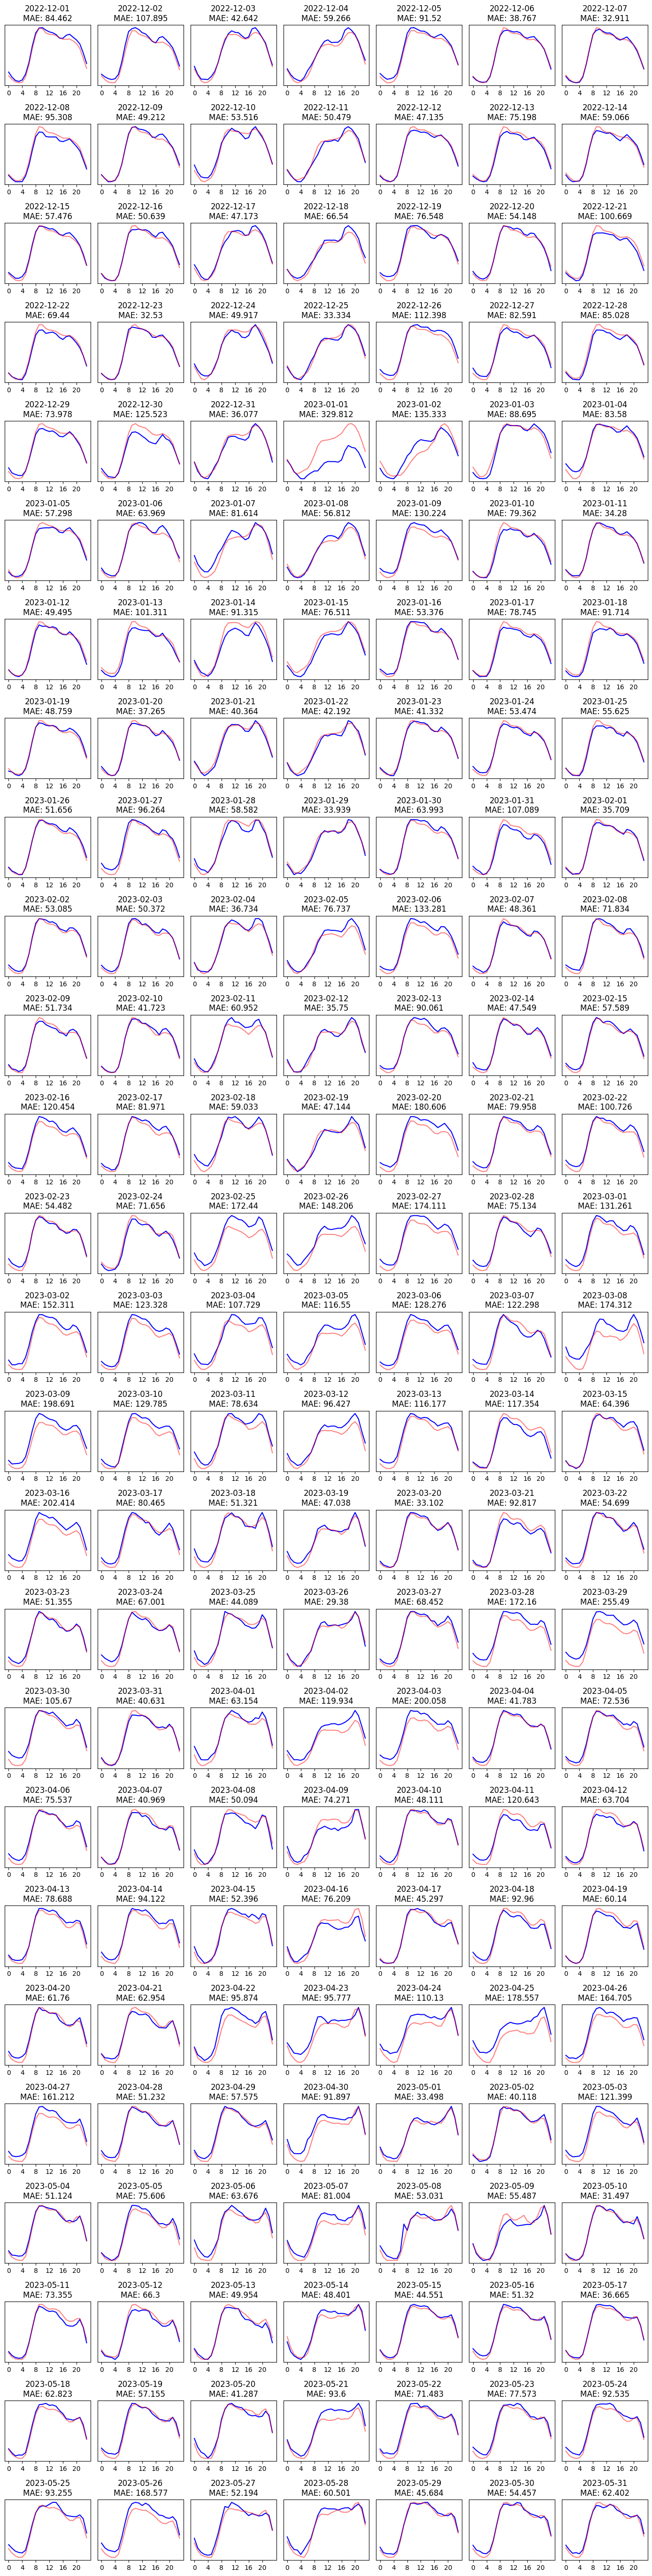

In [19]:
plot_predicts(df_true=df_true,
              df_pred=df_pred,
              days_shift=0)

Итоговый MAE на тестовых данных составил 80.105

In [20]:
# df_true.to_csv('data_for_train/3.6/df_true.csv')
# df_pred.to_csv('data_for_train/3.6/df_pred_NN.csv')